# Concentration dependent elastic constants

Here we demonstrate the new `SQSElasticConstantsList` job, which gets elastic constants as a function of chemical composition.

This job works by using special quasirandom structures (implemented by Dominik Gehringer and Jan Janssen) to create cells with the requested chemical composition from a base crystal structure. These are then evaluated for their elastic constants (implemented by Yuri Lysogorskiy). These are fully relaxed and the basic output is the chemical composition and full 6x6 elastic matrix. (More detailed output is available from the underlying `SQSElasticConstants` job stored in HDF5, but user-friendly bindings are not currently implemented.)

These components were assembled together in a single job (implemented by Liam Huber) that takes a list of dictionaries giving the desired chemical compositions (e.g. `{'Al': 0.95, 'Mg': 0.04, '0': 0.01}` for 95% Aluminium 4% Magnesium and 1% vacancies) and three reference jobs: a `ref_ham` which says how the structures should be interpreted for forces and energies (e.g. a Lammps job with a particular potential) -- the structure of this job provides the base crystal upon which the chemical compositions are imposed -- and `ref_sqs` and `ref_elastic` which hold the input parameters for the SQS and elastic constant calculation components.

The current implementation only facilitates modal run modes and is not heavily tested. The example below takes less than 30 minutes on a single core, so for the purposes of demonstration this is not a serious limitation.

In [56]:
from pyiron_atomistics import Project
import pyiron_gpl
import pyiron_continuum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [57]:
pr = Project('elastic_pipeline_5')
# pr.remove_jobs_silently(recursive=True)

## Run the calculation

Our test system will be Al with dilute Mg (up to 2%). Here we define the reference jobs, give our desired compositions.

Feedback on the most user-friendly way to take chemical composition input (while still being fully flexible in allowed compositions!) is welcome -- this code is still in development.

In [58]:
lmp_mini = pr.create_job(pr.job_type.Lammps, 'lammps_mini')
lmp_mini.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)
lmp_mini.potential = 'AlLi-atomicrex'
lmp_mini.calc_minimize(pressure=0.0)
lmp_mini.run()

/tmp/ipykernel_3025/3578036438.py:2: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.structure.bulk instead.
  lmp_mini.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)


The job lammps_mini was saved and received the ID: 977


In [59]:
sqs_job_al = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqs_job_al"
)
sqs_job_al.structure = lmp_mini.get_structure()
sqs_job_al.input['iterations'] = 1000
master_al = sqs_job_al.create_job(
    job_type=pr.job_type.SQSMaster, 
    job_name="master_al"
)

master_al.input["fraction_lst"] = [0.005, 0.01, 0.015, 0.02]
master_al.input["species_one"] = "Li"
master_al.input["species_two"] = "Al"
master_al.run()

The job master_al was saved and received the ID: 978
The job sqs_0_005 was saved and received the ID: 979


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/structuretoolkit/build/sqs.py:43: UserWarning: The current mole-fraction specification cannot be applied to 500 atoms, as it would lead to fractional occupation. Hence, I have changed it from "{'Li': 0.005, 'Al': 0.995}" -> "{'Li': 0.004, 'Al': 0.996}"
  warnings.warn(


The job sqs_0_01 was saved and received the ID: 980
The job sqs_0_015 was saved and received the ID: 981


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/structuretoolkit/build/sqs.py:43: UserWarning: The current mole-fraction specification cannot be applied to 500 atoms, as it would lead to fractional occupation. Hence, I have changed it from "{'Li': 0.015, 'Al': 0.985}" -> "{'Li': 0.016, 'Al': 0.984}"
  warnings.warn(


The job sqs_0_02 was saved and received the ID: 982


In [60]:
concentration_lst = [0.0] + [0.005, 0.01, 0.015, 0.02]

In [61]:
structure_lst = [lmp_mini.get_structure()] + master_al.list_of_structures

In [62]:
[s.get_chemical_formula() for s in structure_lst]

['Al500', 'Al498Li2', 'Al495Li5', 'Al492Li8', 'Al490Li10']

In [63]:
for s in structure_lst:
    lmp_template = pr.create.job.Lammps('lammps_tmp')
    lmp_template.potential = 'AlLi-atomicrex'
    lmp_template.server.run_mode.interactive = True
    lmp_template.interactive_enforce_structure_reset = True
    lmp_template.structure = s
    elastic = lmp_template.create_job(pr.job_type.ElasticMatrixJob, 'elastic_' + s.get_chemical_formula())
    elastic.input['num_of_points'] = 5
    elastic.input['fit_order'] = 2
    elastic.input['eps_range'] = 0.005
    elastic.input['relax_atoms'] = True
    elastic.input['sqrt_eta'] = True
    elastic.run()

The job elastic_Al500 was saved and received the ID: 983
The job elastic_Al500_lammps_tmp was saved and received the ID: 984


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al498Li2 was saved and received the ID: 985
The job elastic_Al498Li2_lammps_tmp was saved and received the ID: 986


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al495Li5 was saved and received the ID: 987
The job elastic_Al495Li5_lammps_tmp was saved and received the ID: 988


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al492Li8 was saved and received the ID: 989
The job elastic_Al492Li8_lammps_tmp was saved and received the ID: 990


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al490Li10 was saved and received the ID: 991
The job elastic_Al490Li10_lammps_tmp was saved and received the ID: 992


/home/menon/miniconda3/envs/pyiron-damask/lib/python3.11/site-packages/pyiron_atomistics/lammps/interactive.py:502: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


## post-processing the data

The output of the job is stored to HDF5. To verify this, and since the actual calculation may be done at a different time than the results are analyzed, we demonstrate this by loading the job.

There is also a little bit of annoying post-processing to get it all formatted as nice numpy arrays. Some of this is reasonable (like the need to explicitly add 0% Mg to the first chemistry -- we wouldn't want to list *everything that's not there*!), some is "not my fault" (like the way the InputList class mangles our chemistry dictionary on saving it to HDF), and some needs nicer helper functions in the future (like the ability to explicity ask for "C12" and get it by that string).

In [64]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,977,finished,Al500,lammps_mini,/lammps_mini,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/,2023-09-05 21:36:02.665157,2023-09-05 21:36:03.384739,0.0,pyiron@cmleo26#1,Lammps,0.1,None,NaN
1,978,finished,Al500,master_al,/master_al,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/,2023-09-05 21:36:10.666126,2023-09-05 21:36:17.305186,6.0,pyiron@cmleo26#1#4/4,SQSMaster,0.0.1,None,NaN
2,979,finished,Al498Li2,sqs_0_005,/sqs_0_005,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/master_al_hdf5/,2023-09-05 21:36:11.358349,2023-09-05 21:36:12.420125,1.0,pyiron@cmleo26#1,SQSJob,0.1,None,978.0
3,980,finished,Al495Li5,sqs_0_01,/sqs_0_01,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/master_al_hdf5/,2023-09-05 21:36:13.077267,2023-09-05 21:36:14.056435,0.0,pyiron@cmleo26#1,SQSJob,0.1,None,978.0
4,981,finished,Al492Li8,sqs_0_015,/sqs_0_015,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/master_al_hdf5/,2023-09-05 21:36:14.679564,2023-09-05 21:36:15.672337,0.0,pyiron@cmleo26#1,SQSJob,0.1,None,978.0
5,982,finished,Al490Li10,sqs_0_02,/sqs_0_02,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/master_al_hdf5/,2023-09-05 21:36:16.305181,2023-09-05 21:36:17.297217,0.0,pyiron@cmleo26#1,SQSJob,0.1,None,978.0
6,983,finished,Al500,elastic_Al500,/elastic_Al500,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/,2023-09-05 21:36:49.250569,2023-09-05 21:36:53.091974,3.0,pyiron@cmleo26#1#0,ElasticMatrixJob,0.0.1,None,NaN
7,984,finished,Al500,elastic_Al500_lammps_tmp,/elastic_Al500_lammps_tmp,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/elastic_Al500_hdf5/,2023-09-05 21:36:50.202874,2023-09-05 21:36:52.110120,1.0,pyiron@cmleo26#1,Lammps,0.1,None,983.0
8,985,finished,Al498Li2,elastic_Al498Li2,/elastic_Al498Li2,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/,2023-09-05 21:36:53.876232,2023-09-05 21:37:00.125770,6.0,pyiron@cmleo26#1#0,ElasticMatrixJob,0.0.1,None,NaN
9,986,finished,Al498Li2,elastic_Al498Li2_lammps_tmp,/elastic_Al498Li2_lammps_tmp,None,/mnt/c/Users/menon/Documents/winrepos/projects-pyiron/pyiron-workflow-damask/elastic_pipeline_5/elastic_Al498Li2_hdf5/,2023-09-05 21:36:54.483007,2023-09-05 21:36:59.202763,4.0,pyiron@cmleo26#1,Lammps,0.1,None,985.0


In [65]:
def filter_function(job): 
    return "elastic_" in job.job_name and "lammps_tmp" not in job.job_name

In [66]:
def get_c11(job):
    return job["output/elasticmatrix"]["C"][0,0]

def get_c12(job):
    return job["output/elasticmatrix"]["C"][0,1]

def get_c44(job):
    return job["output/elasticmatrix"]["C"][3,3]

In [67]:
table = pr.create_table()

In [68]:
table.filter_function = filter_function
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

In [69]:
table.run()

The job table was saved and received the ID: 993


Loading and filtering jobs:   0%|          | 0/17 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/5 [00:00<?, ?it/s]

In [70]:
df_data = table.get_dataframe()
df_data

,job_id,C11,C12,C44
0,983,111.328444,62.085214,47.596717
1,985,112.539686,61.867094,47.204179
2,987,110.815273,61.702050,46.937037
3,989,110.296774,61.698306,46.655419
4,991,109.942585,61.718508,46.476683


## Analysis

Finally, let's use numpy to make a polynomial fit of our elastic constants to alloying concentration and visualize the results.

Note: pure-Al data lines up very nicely with the pure Al elastic constants [reported on the NIST website for this potential](https://www.ctcms.nist.gov/potentials/entry/2009--Mendelev-M-I-Asta-M-Rahman-M-J-Hoyt-J-J--Al-Mg/2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1.html). I don't have a good sense for exactly what <2% Mg should be doing, but at least there are no sharp changes. Sanity check passed.

In [71]:
concentrations = np.array(concentration_lst)

In [72]:
C11_data = df_data["C11"].values
C12_data = df_data["C12"].values
C44_data = df_data["C44"].values

In [73]:
fit_degree = 2
C11_fit = np.polyfit(concentrations, C11_data, deg=fit_degree)
C12_fit = np.polyfit(concentrations, C12_data, deg=fit_degree)
C44_fit = np.polyfit(concentrations, C44_data, deg=fit_degree)
c = np.linspace(concentrations.min(), concentrations.max(), 100)  # 'Continuous' concentration

In [74]:
# p(x) = p[0] * x**deg + ... + p[deg]
print(C11_fit)
print(C12_fit)
print(C44_fit)

[-5499.8459933      9.70431475   111.71248627]
[1822.69695836  -54.49795855   62.08580959]
[1180.36893367  -79.38393256   47.59079101]


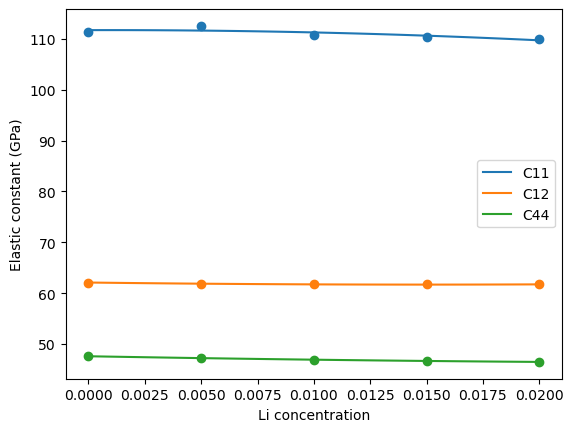

In [75]:
for color, data, fit, label in zip(
    sns.color_palette(n_colors=3), 
    [C11_data, C12_data, C44_data], 
    [C11_fit, C12_fit, C44_fit],
    ['C11', 'C12', 'C44']
):
    plt.scatter(concentrations, data, color=color)
    plt.plot(c, np.polyval(fit, c), color=color, label=label)
plt.xlabel('Li concentration')
plt.ylabel('Elastic constant (GPa)')
plt.legend()
plt.show()

# DAMASK Simulations
The steps include, defining:
- geometries
- grains
- loading
- material properties based on the atomistically-evaluated 
- perfoming simulations

In [76]:
from damask import Rotation

In [77]:
concentrations[::2]

array([0.  , 0.01, 0.02])

In [78]:
job_lst = []
for i,c in enumerate(concentrations[::2]):
    job = pr.create.job.DAMASK("damask_" + 'Li_{}'.format(int(c*100)), delete_aborted_job=True, delete_existing_job=True)
    elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= float(np.polyval(C11_fit, c)),
                                                C_12= float(np.polyval(C12_fit, c)), 
                                                C_44=float(np.polyval(C44_fit, c)))
    phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                             output_list=['F', 'P', 'F_e'],
                             elasticity=elasticity,plasticity=None)
    rotation = pr.continuum.damask.Rotation(Rotation.from_random, 1)
    
    homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                         parameters={'N_constituents': 1,
                                                                     "mechanical": {"type": "pass"}})
    
    # now you can define your material.yaml configuration
    material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)
    
    # now you can save your material to your job
    job.material = material

    grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1., grid_dim=16, num_grains=1)
    
    # save the geometry information to your job
    job.grid = grid

    load_step =[{'mech_bc_dict':{'dot_F':[1e-3,0,0, 0,'x',0,  0,0,'x'],
                                'P':['x','x','x', 'x',0,'x',  'x','x',0]},
                'discretization':{'t': 50.,'N': 50},
                'additional': {'f_out': 5}
               }]
    solver = job.list_solvers()[0] # choose the mechanis solver
    job.loading = pr.continuum.damask.Loading(solver=solver, load_steps=load_step)
    job.run()
    job_lst.append(job)

The job damask_Li_0 was saved and received the ID: 994


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


The job damask_Li_1 was saved and received the ID: 995


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


The job damask_Li_2 was saved and received the ID: 996


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Text(0.5, 1.0, 'Stress-Strain')

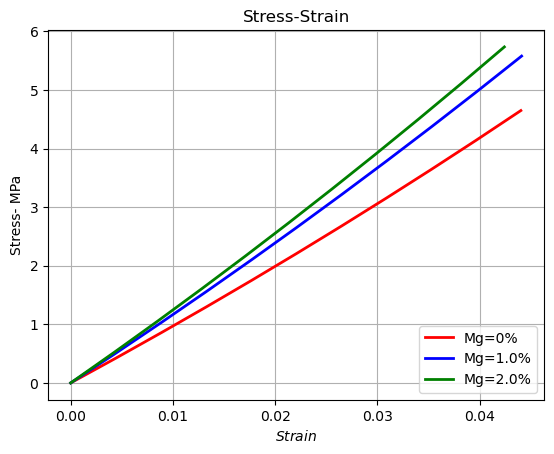

In [79]:
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(job_lst[0].output.strain_von_Mises, job_lst[0].output.stress_von_Mises, 'r', linewidth=2, label = 'Mg={}%'.format(0*100))
plt.plot(job_lst[1].output.strain_von_Mises, job_lst[1].output.stress_von_Mises, 'b', linewidth=2, label = 'Mg={}%'.format(0.01*100))
plt.plot(job_lst[2].output.strain_von_Mises, job_lst[2].output.stress_von_Mises, 'g', linewidth=2, label = 'Mg={}%'.format(0.02*100))
#plt.ylim(90, 95)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")